Librerias necesarias

In [54]:
import os
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
from typing import List, Tuple, Dict, Optional
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import networkx as nx
from scipy.cluster.hierarchy import dendrogram, linkage

Funcion para detectar y recortar la cara 

In [4]:
def detectar_cara(
    image_path: str,
    output_path: str,
    sin_caras_path: str,
    scale_factor: float = 1.1,
    min_neighbors: int = 5,
    color: bool = False,
    img_size: Optional[Tuple[int, int]] = None
) -> Optional[Tuple[int, int, int, int]]:
    """
    Detecta y guarda la cara más grande de una imagen, con redimensionado opcional.

    Args:
        image_path: Ruta de la imagen original
        output_path: Ruta donde se guarda la cara recortada
        sin_caras_path: Carpeta donde se guarda la imagen si no se detectan caras
        scale_factor: Parámetro para ajustar el escalado del detector
        min_neighbors: Cantidad mínima de vecinos para validar una detección
        color: Si True, guarda la cara en color; si False, en escala de grises
        img_size: Tamaño deseado para redimensionar la cara (ancho, alto)

    Returns:
        Coordenadas de la cara detectada, o None si no se detectó
    """
    img = cv2.imread(image_path)
    if img is None:
        print(f"[ERROR] No se pudo cargar la imagen: {image_path}")
        return None

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, scaleFactor=scale_factor, minNeighbors = min_neighbors)

    if len(faces) == 0:
        print(f"[INFO] No se detectó ninguna cara en {image_path}")
        os.makedirs(sin_caras_path, exist_ok=True)
        no_face_path = os.path.join(sin_caras_path, os.path.basename(image_path))
        cv2.imwrite(no_face_path, img)
        print(f"[GUARDADO] Imagen sin cara: {no_face_path}")
        return None

    x, y, w, h = max(faces, key=lambda rect: rect[2] * rect[3])
    if w < 30 or h < 30:
        print(f"[INFO] Cara demasiado pequeña en {image_path}")
        return None

    face_crop = img[y:y+h, x:x+w] if color else gray[y:y+h, x:x+w]

    # Redimensionar si se indicó tamaño
    if img_size:
        face_crop = cv2.resize(face_crop, img_size)

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    cv2.imwrite(output_path, face_crop)
    print(f"[GUARDADO] Cara guardada en: {output_path}")

    return (x, y, w, h)

In [7]:
def procesar_carpeta(
    input_folder,
    output_folder,
    sin_caras_folder,
    img_size: Optional[Tuple[int, int]] = None
):
    """
    Procesa todas las imágenes en subcarpetas del input_folder, detecta caras
    y las guarda redimensionadas en la estructura correspondiente.

    Args:
        input_folder: Carpeta con subcarpetas por persona
        output_folder: Carpeta destino de caras recortadas
        sin_caras_folder: Carpeta para imágenes donde no se detecta cara
        img_size: Tamaño deseado para redimensionar las caras (ancho, alto)
    """
    for subdir, _, files in os.walk(input_folder):
        if not files:
            continue

        persona = os.path.basename(subdir)
        output_subdir = os.path.join(output_folder, persona)
        os.makedirs(output_subdir, exist_ok=True)

        for file in files:
            if not file.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue

            input_path = os.path.join(subdir, file)
            output_path = os.path.join(output_subdir, file)

            detectar_cara(
                image_path=input_path,
                output_path=output_path,
                sin_caras_path=sin_caras_folder,
                scale_factor=1.1,
                min_neighbors=5,
                color=False,
                img_size=img_size
            )

In [8]:
input_folder = '../Eigenfaces/Eigenfaces'
output_folder = '../Eigenfaces/procesadas'
sin_caras_folder = '../Eigenfaces/sin_caras'

# Por ejemplo, para guardar todo en 64x64
procesar_carpeta(input_folder, output_folder, sin_caras_folder, img_size=(64, 64))

[GUARDADO] Cara guardada en: ../Eigenfaces/procesadas/Jorgelina/IMG_20250321_140522457.jpg
[GUARDADO] Cara guardada en: ../Eigenfaces/procesadas/Jorgelina/1742907849966.jpg
[GUARDADO] Cara guardada en: ../Eigenfaces/procesadas/Jorgelina/IMG_6807.jpeg
[GUARDADO] Cara guardada en: ../Eigenfaces/procesadas/Jorgelina/IMG_4172.JPG
[GUARDADO] Cara guardada en: ../Eigenfaces/procesadas/Jorgelina/IMG_4170.JPG
[GUARDADO] Cara guardada en: ../Eigenfaces/procesadas/Jorgelina/IMG_7647.JPG
[GUARDADO] Cara guardada en: ../Eigenfaces/procesadas/Jorgelina/IMG_4171.JPG
[GUARDADO] Cara guardada en: ../Eigenfaces/procesadas/Jorgelina/IMG_20250321_140524420_HDR.jpg
[GUARDADO] Cara guardada en: ../Eigenfaces/procesadas/Jorgelina/IMG_8662.jpeg
[GUARDADO] Cara guardada en: ../Eigenfaces/procesadas/Jorgelina/IMG_6806.jpeg
[GUARDADO] Cara guardada en: ../Eigenfaces/procesadas/Jorgelina/IMG_8661.jpeg
[GUARDADO] Cara guardada en: ../Eigenfaces/procesadas/Jorgelina/IMG_6805.jpeg
[GUARDADO] Cara guardada en: ../Ei

Cargar las caras y prepararlas para aplicar PCA 

In [6]:
def cargar_dataset_con_labels(
    base_folder: str
) -> Tuple[np.ndarray, np.ndarray, Dict[str, int], np.ndarray]:
    """
    Carga imágenes desde subcarpetas (una por persona), ya redimensionadas y listas.

    Args:
        base_folder: Carpeta con subcarpetas por persona.

    Returns:
        X: np.ndarray con imágenes aplanadas (n_imágenes, ancho × alto)
        y: np.ndarray con etiquetas numéricas
        label_dict: dict {nombre_persona: clase_numérica}
        y_names: np.ndarray con los nombres de las personas
    """
    X = []
    y = []
    y_names = []
    label_dict = {}
    label_counter = 0
    base_path = Path(base_folder)

    for person_folder in base_path.iterdir():
        if not person_folder.is_dir():
            continue

        person_name = person_folder.name
        if person_name not in label_dict:
            label_dict[person_name] = label_counter
            label_counter += 1

        for img_file in person_folder.iterdir():
            if img_file.suffix.lower() not in {'.jpg', '.jpeg', '.png'}:
                continue

            img = cv2.imread(str(img_file), cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"[WARNING] No se pudo leer {img_file}")
                continue

            X.append(img.flatten())
            y.append(label_dict[person_name])
            y_names.append(person_name)

    X = np.array(X)
    y = np.array(y)
    y_names = np.array(y_names)

    print(f"[INFO] Se cargaron {X.shape[0]} imágenes de {len(label_dict)} personas.")
    return X, y, label_dict, y_names

In [7]:
def mostrar_imagenes_aleatorias_auto(X, y_names, n=6, seed=42):
    """
    Muestra n imágenes aleatorias con sus etiquetas, detectando automáticamente el tamaño.

    Args:
        X: matriz de imágenes aplanadas (n_muestras, n_pixeles)
        y_names: lista de nombres por imagen
        n: cantidad de imágenes a mostrar
        seed: semilla para reproducibilidad
    """
    # Detectar tamaño de imagen cuadrada automáticamente
    total_pixeles = X.shape[1]
    lado = int(np.sqrt(total_pixeles))
    
    if lado * lado != total_pixeles:
        print(f"[ERROR] Las imágenes no parecen cuadradas: {total_pixeles} pixeles no forman un cuadrado perfecto.")
        return

    np.random.seed(seed)
    indices = np.random.choice(len(X), size=n, replace=False)

    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(indices):
        img = X[idx].reshape((lado, lado))
        plt.subplot(1, n, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(y_names[idx])
        plt.axis('off')
    plt.suptitle(f"{n} imágenes aleatorias del dataset", fontsize=14)
    plt.tight_layout()
    plt.show()

In [8]:
X, y, label_dict, y_names = cargar_dataset_con_labels(output_folder)

[INFO] Se cargaron 293 imágenes de 13 personas.


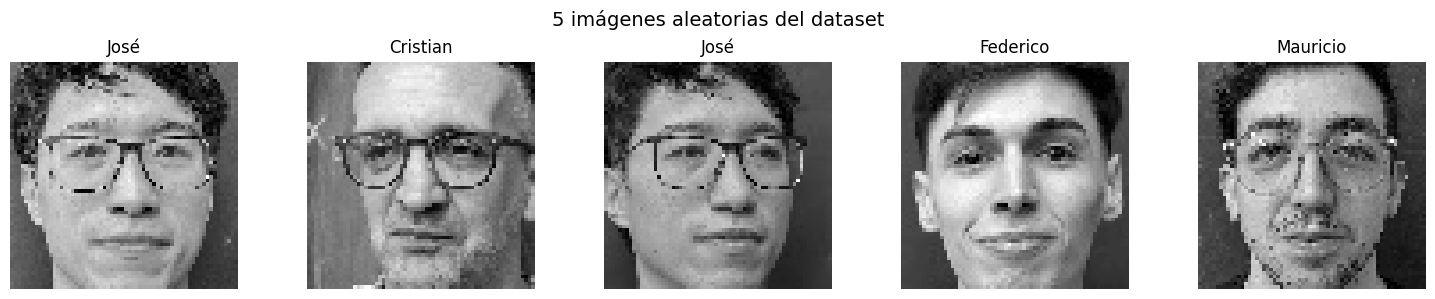

In [12]:
mostrar_imagenes_aleatorias_auto(X, y_names, n = 5, seed = 21)

Cara promedio

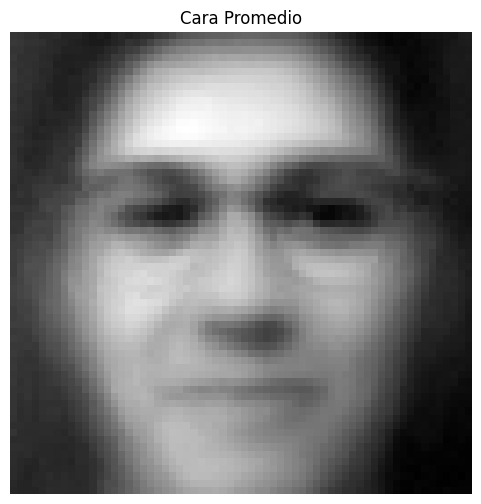

In [13]:
mean_face = np.mean(X, axis = 0)

# Convertir a imagen 2D
mean_face_image = mean_face.reshape(64, 64)

# Visualizar la cara promedio
plt.figure(figsize=(6, 6))
plt.imshow(mean_face_image, cmap='gray')
plt.title("Cara Promedio")
plt.axis('off')
plt.show()

In [27]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [28]:
pca = PCA(n_components = 0.85)  # Mantener el 85% de la varianza
X_pca = pca.fit_transform(X_scaled)

print(f"[INFO] Se redujo la dimensionalidad de {X.shape[1]} a {X_pca.shape[1]} componentes principales.")

[INFO] Se redujo la dimensionalidad de 4096 a 71 componentes principales.


Grafico de la varianza explicada

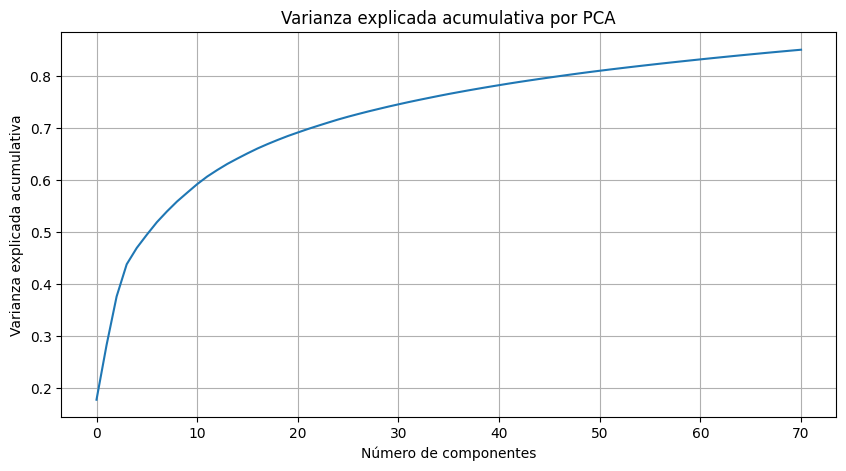

In [29]:
#Varianza explicada
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Varianza explicada acumulativa por PCA')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza explicada acumulativa')
plt.grid()
plt.show()


Mostrar componentes principales elegidas

In [41]:
def mostrar_componentes(pca, componentes_idx, img_size=(64, 64)):
    """
    Muestra las componentes principales específicas indicadas por el usuario.

    Args:
        pca: objeto PCA ya ajustado
        componentes_idx: lista de índices de componentes (por ejemplo [0, 4, 10])
        img_size: tamaño (ancho, alto) de las imágenes originales
    """
    n = len(componentes_idx)
    rows = 2
    cols = (n + 1) // rows

    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
    axes = axes.flatten()

    for i, idx in enumerate(componentes_idx):
        comp = pca.components_[idx]
        ax = axes[i]
        ax.imshow(comp.reshape(img_size), cmap='gray')
        var_exp = pca.explained_variance_ratio_[idx] * 100
        ax.set_title(f"Comp {idx + 1} ({var_exp:.2f}% var)")
        ax.axis('off')

    for ax in axes[n:]:
        ax.axis('off')

    plt.suptitle("Componentes específicas seleccionadas", fontsize=14)
    plt.tight_layout()
    plt.show()


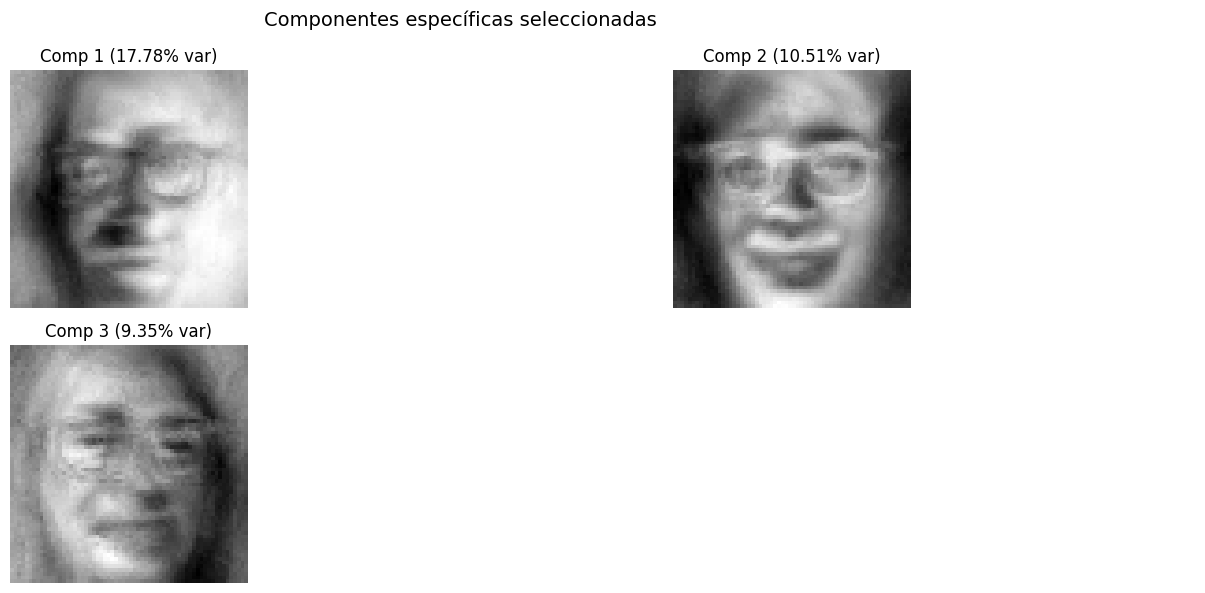

In [49]:
# Mostrar las componentes 
componentes_a_mostrar = [0, 1, 2]
mostrar_componentes(pca, componentes_a_mostrar, img_size=(64, 64))

In [48]:
def mostrar_componentes_principales(pca, n=5, ultimas=False, img_size=(64, 64)):
    """
    Muestra las primeras o últimas n componentes principales del PCA.

    Args:
        pca: objeto PCA ya ajustado
        n: número de componentes a mostrar
        ultimas: si True, muestra las últimas n en lugar de las primeras
        img_size: tamaño para reconstruir las imágenes (ancho, alto)
    """
    total = pca.components_.shape[0]
    if ultimas:
        componentes = pca.components_[-n:]
        indices = list(range(total - n + 1, total + 1))
        titulo = f"Últimas {n} Componentes Principales"
    else:
        componentes = pca.components_[:n]
        indices = list(range(1, n + 1))
        titulo = f"Primeras {n} Componentes Principales"

    rows = 2
    cols = (n + 1) // rows
    fig, axes = plt.subplots(rows, cols, figsize=(15, 8))
    axes = axes.flatten()
    for i in range(n):
        ax = axes[i]
        ax.imshow(componentes[i].reshape(img_size), cmap='gray')
        ax.set_title(f"Componente {indices[i]}")
        ax.axis('off')
    for ax in axes[n:]:
        ax.axis('off')
    plt.suptitle(titulo, fontsize=14)
    plt.tight_layout()
    plt.show()

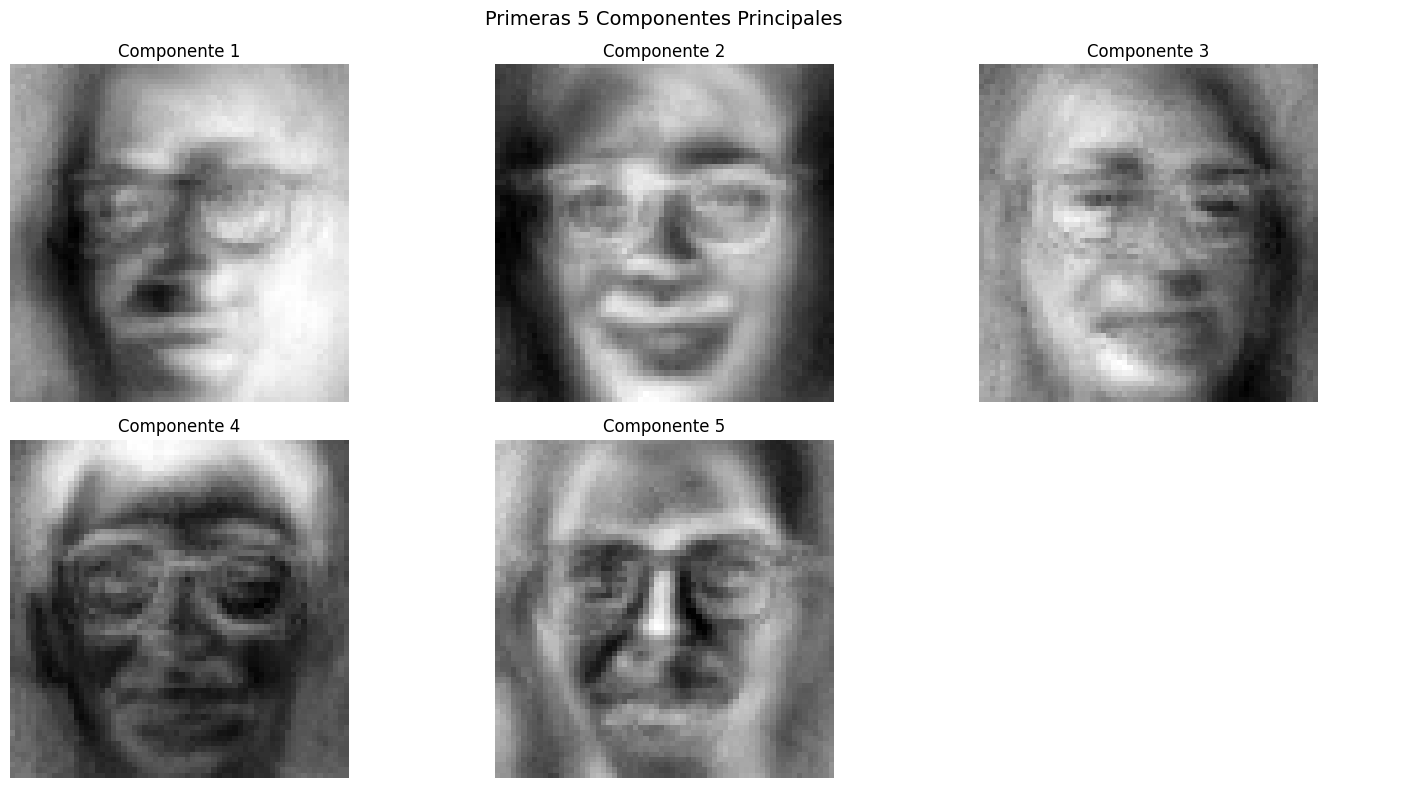

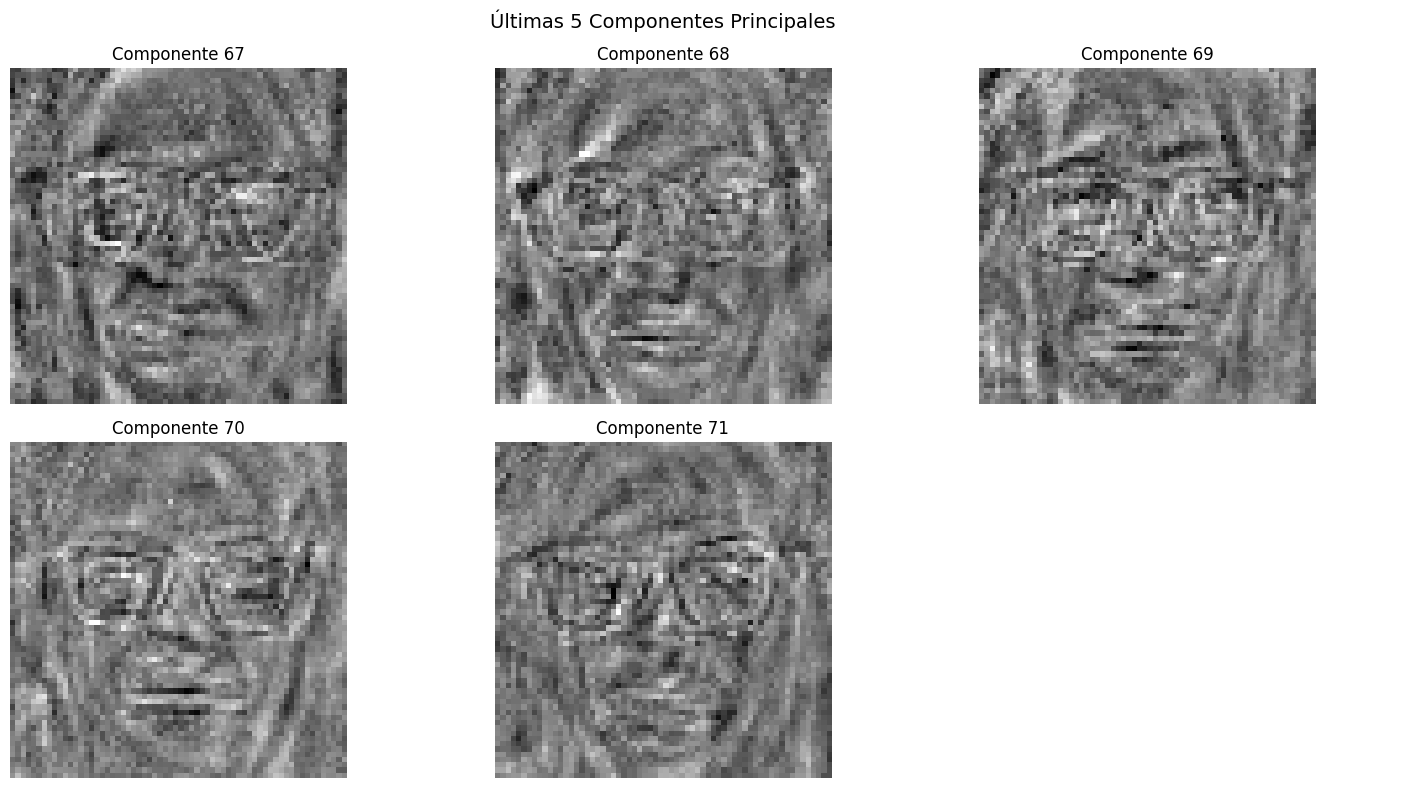

In [47]:
# Mostrar las primeras 5
mostrar_componentes_principales(pca, n=5, ultimas=False)

# Mostrar las últimas 5
mostrar_componentes_principales(pca, n=5, ultimas=True)

Reconstruir imagenes con PCA

In [57]:
def reconstruir_desde_pca(X_pca, pca, scaler):
    """
    Reconstruye las imágenes originales a partir de sus representaciones PCA.

    Args:
        X_pca: matriz reducida (output de pca.transform)
        pca: objeto PCA entrenado
        scaler: objeto StandardScaler entrenado

    Returns:
        X_reconstruida: matriz reconstruida (con forma y escala original)
    """
    # 1. Volver al espacio estandarizado
    X_estandarizado = pca.inverse_transform(X_pca)
    
    # 2. Deshacer la estandarización
    X_reconstruida = scaler.inverse_transform(X_estandarizado)
    
    return X_reconstruida

In [58]:
X_reconstruida = reconstruir_desde_pca(X_pca, pca, scaler)

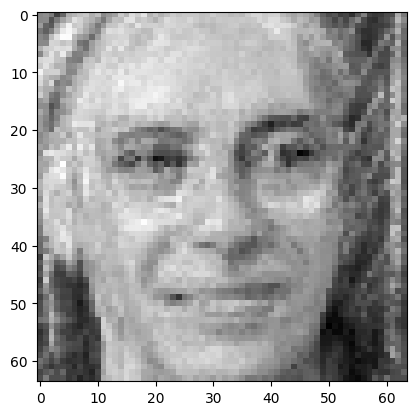

In [68]:
plt.imshow(X_reconstruida[292].reshape((64, 64)), cmap='gray')

In [55]:
def mostrar_reconstrucciones(
    X, X_pca, pca, scaler,
    indices=None, n=10, aleatorio=False,
    img_size=(64, 64), seed=42
):
    """
    Muestra imágenes originales y sus reconstrucciones desde PCA, con MSE.

    Args:
        X: matriz original (no escalada)
        X_pca: matriz reducida (salida de pca.transform)
        pca: objeto PCA entrenado
        scaler: objeto StandardScaler usado para escalar X
        indices: lista opcional de índices de imágenes a mostrar
        n: cantidad de imágenes a mostrar (si no se pasan índices)
        aleatorio: si True, elige n imágenes al azar
        img_size: tamaño original de las imágenes
        seed: para reproducibilidad cuando aleatorio=True
    """
    # Reconstrucción completa
    X_pca_inv = pca.inverse_transform(X_pca)
    X_reconstruido = scaler.inverse_transform(X_pca_inv)

    # Seleccionar índices
    total = X.shape[0]
    if indices is not None:
        selected_idx = indices
    elif aleatorio:
        np.random.seed(seed)
        selected_idx = np.random.choice(total, size=n, replace=False)
    else:
        selected_idx = np.arange(n)

    plt.figure(figsize=(15, 4))
    for i, idx in enumerate(selected_idx):
        original = X[idx].reshape(img_size)
        reconstruida = X_reconstruido[idx].reshape(img_size)
        mse = mean_squared_error(original, reconstruida)

        # Original
        plt.subplot(2, len(selected_idx), i + 1)
        plt.imshow(original, cmap='gray')
        plt.title(f"Original {idx}")
        plt.axis('off')

        # Reconstrucción
        plt.subplot(2, len(selected_idx), i + 1 + len(selected_idx))
        plt.imshow(reconstruida, cmap='gray')
        plt.title(f"Rec {idx}\nMSE: {mse:.2f}")
        plt.axis('off')

    plt.suptitle("Reconstrucción con PCA (con error MSE)", fontsize=14)
    plt.tight_layout()
    plt.show()

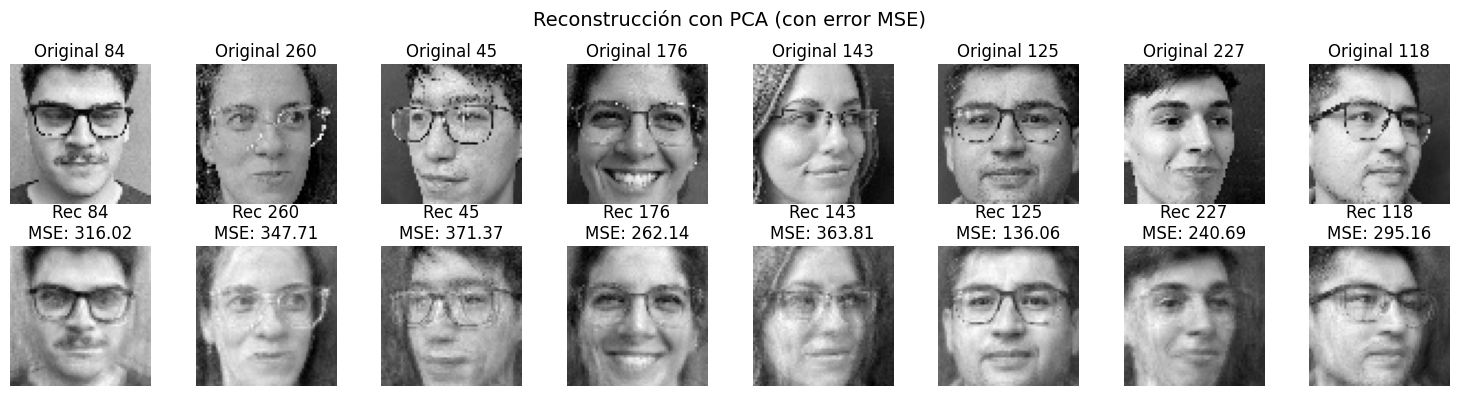

In [56]:
mostrar_reconstrucciones(X, X_pca, pca, scaler, aleatorio=True, n=8, img_size=(64, 64))

In [25]:
def top_parejas_mas_parecidas_entre_personas(X, y, y_names, top_n=5):
    """
    Muestra las N parejas de imágenes más parecidas entre personas distintas.

    Args:
        X: matriz de imágenes aplanadas
        y: etiquetas numéricas
        y_names: nombres de personas
        top_n: cuántas parejas mostrar
    """
    total_pixeles = X.shape[1]
    lado = int(np.sqrt(total_pixeles))

    if lado * lado != total_pixeles:
        print("[ERROR] Las imágenes no son cuadradas.")
        return

    # Calcular matriz de distancias
    dist_matrix = squareform(pdist(X, metric='euclidean'))
    np.fill_diagonal(dist_matrix, np.inf)

    # Enmascarar comparaciones entre la misma persona
    mask = np.equal.outer(y, y)
    dist_matrix[mask] = np.inf

    # Obtener los índices de las N distancias más bajas
    indices = np.dstack(np.unravel_index(np.argsort(dist_matrix, axis=None), dist_matrix.shape))[0]

    # Filtrar duplicados simétricos (i, j) y (j, i)
    pares_vistos = set()
    top_pares = []
    for i, j in indices:
        if (j, i) in pares_vistos or y[i] == y[j]:
            continue
        pares_vistos.add((i, j))
        top_pares.append((i, j, dist_matrix[i, j]))
        if len(top_pares) == top_n:
            break

    # Mostrar los pares
    for k, (i, j, dist) in enumerate(top_pares, 1):
        print(f"\n🔹 Pareja #{k}:")
        print(f"🧍 {y_names[i]} (idx {i})  vs  🧍 {y_names[j]} (idx {j})")
        print(f"📏 Distancia: {dist:.2f}")

        # Mostrar lado a lado
        plt.figure(figsize=(4, 2))
        for idx, pos in enumerate([i, j]):
            img = X[pos].reshape((lado, lado))
            plt.subplot(1, 2, idx + 1)
            plt.imshow(img, cmap='gray')
            plt.title(f"{y_names[pos]} (idx {pos})")
            plt.axis('off')
        plt.suptitle(f"Pareja #{k}: Caras más parecidas entre personas")
        plt.tight_layout()
        plt.show()

Las imágenes más parecidas entre personas son:
🧍‍♂️ Agustín (idx 192)  vs  🧍‍♀️ Federico (idx 230)
📏 Distancia euclidiana: 2112.73


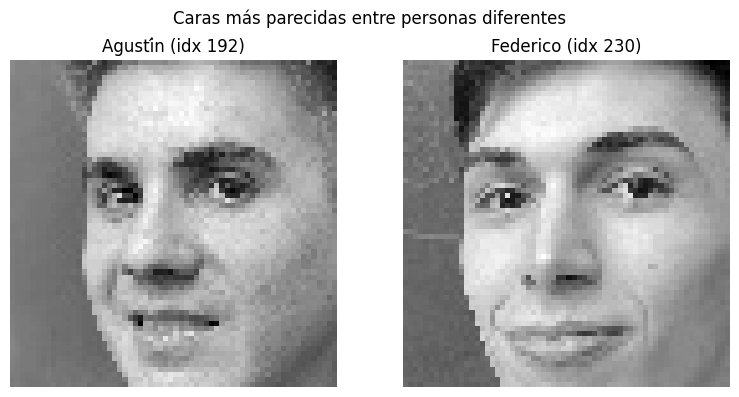


🔹 Pareja #1:
🧍 Agustín (idx 192)  vs  🧍 Federico (idx 230)
📏 Distancia: 2112.73


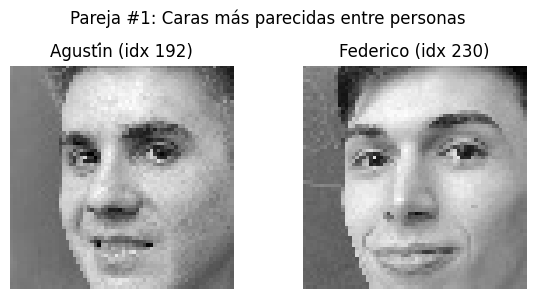


🔹 Pareja #2:
🧍 Federico (idx 230)  vs  🧍 Agustín (idx 199)
📏 Distancia: 2203.65


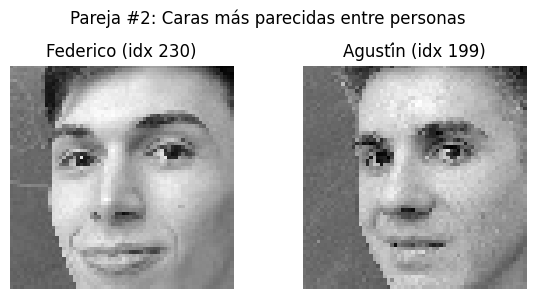


🔹 Pareja #3:
🧍 Guadalupe (idx 254)  vs  🧍 Agustín (idx 195)
📏 Distancia: 2219.04


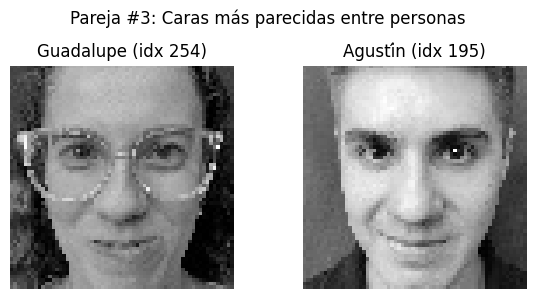


🔹 Pareja #4:
🧍 Daniel (idx 128)  vs  🧍 Federico (idx 234)
📏 Distancia: 2231.74


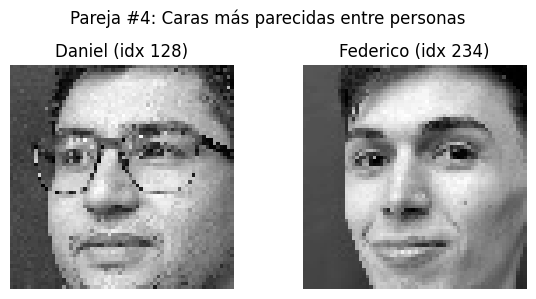


🔹 Pareja #5:
🧍 Federico (idx 234)  vs  🧍 Agustín (idx 180)
📏 Distancia: 2252.43


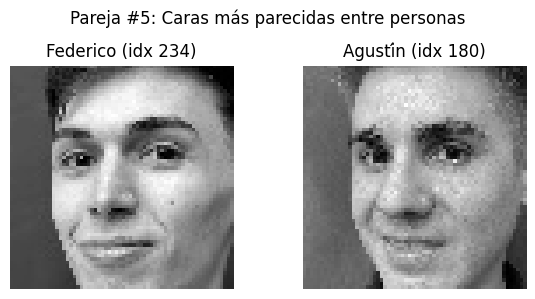

In [ ]:
top_parejas_mas_parecidas_entre_personas(X, y, y_names, top_n=5)

Cara promedio por persona. 

In [24]:
# Invertir el dict para obtener nombre por clase
inv_label_dict = {v: k for k, v in label_dict.items()}

# Crear cara promedio por persona
caras_por_persona = {}
for clase in np.unique(y):
    indices = np.where(y == clase)[0]
    X_persona = X[indices]
    cara_promedio = np.mean(X_persona, axis=0)
    nombre = inv_label_dict[clase]
    caras_por_persona[nombre] = cara_promedio

# Convertimos las caras promedio a una matriz
nombres = list(caras_por_persona.keys())
X_avg = np.array([caras_por_persona[n] for n in nombres])

# Distancia euclidiana (o cosine)
dist_matrix = squareform(pdist(X_avg, metric='euclidean'))

In [25]:
np.fill_diagonal(dist_matrix, np.inf)  # Evitar compararse a sí mismo

i, j = np.unravel_index(np.argmin(dist_matrix), dist_matrix.shape)
print(f"👥 Las personas más parecidas son: {nombres[i]} y {nombres[j]}")
print(f"🔍 Distancia entre sus caras promedio: {dist_matrix[i, j]:.2f}")

👥 Las personas más parecidas son: Mauricio y Daniel
🔍 Distancia entre sus caras promedio: 1347.46


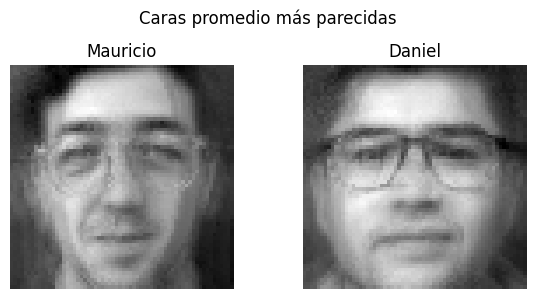

In [23]:
def mostrar_caras_promedio(X_avg, nombres, indices, img_size=(64, 64)):
    i, j = indices
    plt.figure(figsize=(6, 3))
    for idx, pos in enumerate([i, j]):
        cara = X_avg[pos].reshape(img_size)
        plt.subplot(1, 2, idx + 1)
        plt.imshow(cara, cmap='gray')
        plt.title(nombres[pos])
        plt.axis('off')
    plt.suptitle("Caras promedio más parecidas")
    plt.tight_layout()
    plt.show()

mostrar_caras_promedio(X_avg, nombres, (i, j), img_size=(64, 64))

In [36]:
def ranking_similitud_entre_personas(dist_matrix: np.ndarray, nombres: list, top_n: int = 3):
    """
    Muestra un ranking de personas más parecidas a cada una, usando sus caras promedio.

    Args:
        dist_matrix: matriz de distancias entre caras promedio (con np.inf en la diagonal)
        nombres: lista de nombres en el mismo orden que la matriz
        top_n: cantidad de personas más parecidas a mostrar
    """
    for i, nombre in enumerate(nombres):
        # Ordenamos las distancias (excepto a sí mismo)
        indices_ordenados = np.argsort(dist_matrix[i])
        similares = [(nombres[j], dist_matrix[i, j]) for j in indices_ordenados[:top_n]]

        print(f"\n👤 {nombre} se parece más a:")
        for j, (otro_nombre, dist) in enumerate(similares, start=1):
            print(f"   {j}. {otro_nombre} (distancia = {dist:.2f})")

In [37]:
# Asumiendo que ya hiciste:
# X_avg: matriz con caras promedio
# nombres: lista con nombres de personas
# dist_matrix: matriz de distancias entre personas

ranking_similitud_entre_personas(dist_matrix, nombres, top_n=5)


👤 Jorgelina se parece más a:
   1. Natalia (distancia = 1484.01)
   2. Agustín (distancia = 1518.01)
   3. Alejandro (distancia = 1572.45)
   4. Daniel (distancia = 1759.18)
   5. Noelia_R (distancia = 1765.20)

👤 Noelia_M se parece más a:
   1. Federico (distancia = 1801.39)
   2. Noelia_R (distancia = 1923.76)
   3. Daniel (distancia = 1984.78)
   4. Mauricio (distancia = 2013.26)
   5. José (distancia = 2161.23)

👤 José se parece más a:
   1. Daniel (distancia = 1557.37)
   2. Mauricio (distancia = 1664.38)
   3. Federico (distancia = 1688.89)
   4. Noelia_R (distancia = 1951.57)
   5. Agustín (distancia = 2002.02)

👤 Gabriel se parece más a:
   1. Cristian (distancia = 2370.21)
   2. Daniel (distancia = 2409.51)
   3. Agustín (distancia = 2534.37)
   4. Noelia_R (distancia = 2613.52)
   5. Mauricio (distancia = 2723.90)

👤 Mauricio se parece más a:
   1. Daniel (distancia = 1347.46)
   2. Noelia_R (distancia = 1558.22)
   3. Agustín (distancia = 1659.84)
   4. José (distanc

In [38]:
def top_pares_mas_parecidos(dist_matrix: np.ndarray, nombres: list, top_n: int = 10):
    """
    Calcula el top N de pares de personas más parecidas entre sí.

    Args:
        dist_matrix: matriz simétrica de distancias (NxN)
        nombres: lista de nombres en el mismo orden que la matriz
        top_n: cantidad de pares más similares a mostrar

    Returns:
        DataFrame con columnas: Persona A, Persona B, Distancia
    """
    n = len(nombres)
    pares = []

    for i in range(n):
        for j in range(i + 1, n):  # solo pares únicos (sin repetir ni comparar consigo mismo)
            pares.append((nombres[i], nombres[j], dist_matrix[i, j]))

    # Ordenar por distancia
    pares_ordenados = sorted(pares, key=lambda x: x[2])

    # Convertir a DataFrame
    df_top = pd.DataFrame(pares_ordenados[:top_n], columns=["Persona A", "Persona B", "Distancia"])
    return df_top

In [39]:
df_top10 = top_pares_mas_parecidos(dist_matrix, nombres, top_n=10)
print(df_top10)

   Persona A  Persona B    Distancia
0   Mauricio     Daniel  1347.462979
1     Daniel   Agustín  1470.729803
2  Jorgelina    Natalia  1484.005783
3     Daniel   Noelia_R  1512.645064
4  Jorgelina   Agustín  1518.011166
5   Agustín  Alejandro  1532.807323
6   Cristian  Alejandro  1533.603233
7      José     Daniel  1557.374157
8   Mauricio   Noelia_R  1558.221506
9  Jorgelina  Alejandro  1572.450554


In [49]:
def grafo_similitud(dist_matrix, nombres, top_n=1):
    G = nx.Graph()

    # Agregar nodos
    for name in nombres:
        G.add_node(name)

    # Agregar aristas con top_n más parecidos
    for i, name in enumerate(nombres):
        vecinos = np.argsort(dist_matrix[i])[:top_n]
        for j in vecinos:
            if i != j:
                G.add_edge(name, nombres[j], weight=round(dist_matrix[i, j], 2))

    # Dibujar grafo
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(10, 8))
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightblue', font_size=10, font_weight='bold')
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.title("Grafo de similitud entre personas (caras promedio)")
    plt.show()

In [ ]:
grafo_similitud(dist_matrix, nombres, top_n=1)  # o top_n=3 para más conexiones

In [ ]:
# Crear grafo
G = nx.Graph()

# Agregar nodos y aristas con pesos
for p1, p2, dist in similar_pairs:
    G.add_edge(p1, p2, weight=dist)

# Posiciones para los nodos
pos = nx.spring_layout(G, seed=42)

# Dibujar nodos y etiquetas
plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=1500)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

# Dibujar aristas con pesos como etiquetas
edges = G.edges(data=True)
nx.draw_networkx_edges(G, pos, edgelist=edges)
edge_labels = {(u, v): f"{d['weight']:.0f}" for u, v, d in edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

plt.title("Red de Similitud entre Personas (Distancia entre Caras Promedio)")
plt.axis('off')
plt.tight_layout()
plt.show()

In [52]:
def dendrograma_similitud(X_avg, nombres):
    linked = linkage(X_avg, method='ward')  # podés probar 'average' también

    plt.figure(figsize=(10, 6))
    dendrogram(linked, labels=nombres, orientation='right', leaf_font_size=10)
    plt.title("Dendrograma de similitud entre caras promedio")
    plt.tight_layout()
    plt.show()

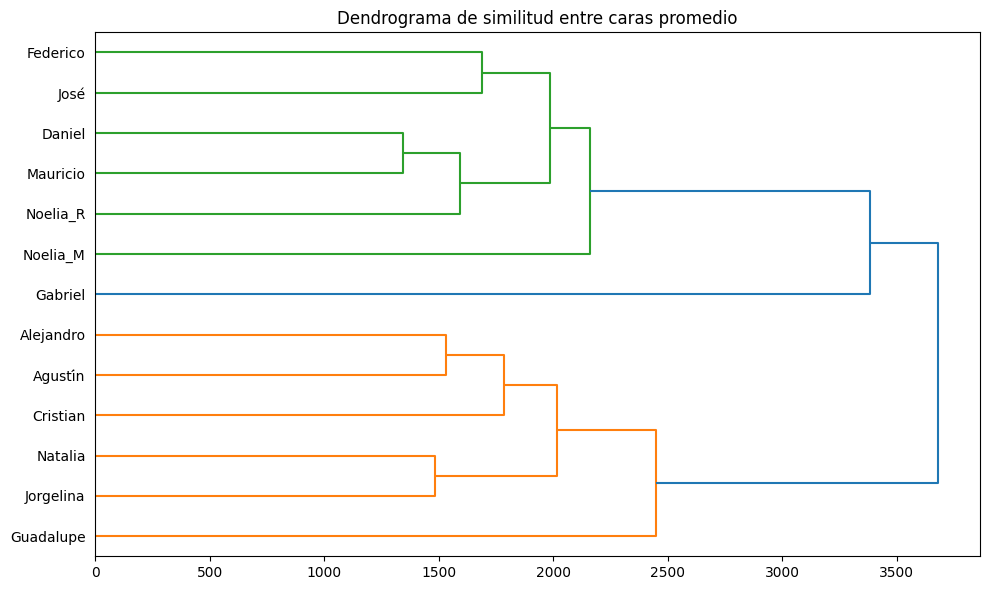

In [181]:
dendrograma_similitud(X_avg, nombres)

X.shape = (293, 4096)
¿Hay NaN en X_scaled? False
¿Hay Inf en X_scaled? False


In [40]:
def visualizar_redimensiones(
    image_path: str,
    tamaños: List[Tuple[int, int]] = [(30, 30), (64, 64), (128, 128)]
) -> None:
    """
    Muestra cómo se ve una imagen redimensionada a diferentes resoluciones.

    Args:
        image_path: Ruta a una imagen en escala de grises
        tamaños: Lista de tamaños (ancho, alto) a comparar
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"[ERROR] No se pudo leer la imagen: {image_path}")
        return

    n = len(tamaños)
    plt.figure(figsize=(4 * n, 4))
    for i, size in enumerate(tamaños):
        resized = cv2.resize(img, size)
        plt.subplot(1, n, i + 1)
        plt.imshow(resized, cmap='gray')
        plt.title(f"{size[0]}×{size[1]}")
        plt.axis('off')
    
    plt.suptitle(f"Comparación de resoluciones para: {Path(image_path).name}", fontsize=14)
    plt.tight_layout()
    plt.show()


visualizar_redimensiones("output_faces/mi_cara.jpg", tamaños=[(30, 30), (64, 64), (128, 128)])

[ERROR] No se pudo leer la imagen: output_faces/mi_cara.jpg


[ WARN:0@47281.049] global loadsave.cpp:268 findDecoder imread_('output_faces/mi_cara.jpg'): can't open/read file: check file path/integrity
